In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
import numpy as np
import scipy as sp
import scipy.integrate
import os
import sys
import itertools as it
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
np.set_printoptions(linewidth=120)

In [23]:
def c2xyz(p):
    x, r, phi = p
    return x, r*np.cos(phi), r*np.sin(phi)

def xyz2c(xyz):
    x, y, z = xyz
    return x, np.sqrt(y**2 + z**2), np.arctan2(z, y)

def transform_matrix(p):
    "Return transformation matrix or a stack of such matrices"
    x, r, phi = p
    Q = np.zeros(np.shape(phi) + (3, 3))
    Q[...,0,0] = 1
    Q[...,1,1] = Q[...,2,2] = np.cos(phi)
    Q[...,2,1] = -np.sin(phi)
    Q[...,1,2] = np.sin(phi)
    return Q

def tensor_c2xyz(A, p):
    Q = transform_matrix(p)
    return np.einsum('...ij,...ik,...jl->...kl', A, Q, Q)

def tensor_xyz2c(A, xyz):
    Q = transform_matrix(xyz2c(xyz))
    return np.einsum('...ij,...ki,...lj->...kl', A, Q, Q)

def vector_c2xyz(v, p):
    Q = transform_matrix(p)
    return np.einsum('...i,...ik->...k', v, Q)

def vector_xyz2c(v, xyz):
    Q = transform_matrix(xyz2c(xyz))
    return np.einsum('...i,...ki->...k', v, Q)

def plot(field, x, r_points=500, phi_points=500, figsize=4, xyz=True):
    polar_field = field(x)
    r = np.linspace(*polar_field.mesh.mesh1.endpoints, r_points)
    phi = np.linspace(*polar_field.mesh.mesh2.endpoints, phi_points)
    data = polar_field(r, phi)
    rank = data.ndim - 2
    if xyz:
        if rank == 2:
            data = tensor_c2xyz(data, (x,) + np.ix_(r, phi))
        elif rank == 1:
            data = vector_c2xyz(data, (x,) + np.ix_(r, phi))
        coord_names = 'xyz'
    else:
        coord_names = 'xrφ'
        
    names = list(''.join(t) for t in it.product(coord_names, repeat=rank))
    
    rows, cols = np.atleast_2d(data[0, 0]).shape
    data = data.reshape(data.shape[:2] + (-1,))

    plt.figure(figsize=(figsize*cols, figsize*rows))
    for i in range(cols*rows):
        ax = plt.subplot(rows, cols, 1 + i, projection="polar")
        m = ax.pcolormesh(phi, r, data[...,i], vmin=data.min(), vmax=data.max())
        plt.xticks([])
        plt.yticks([])
        plt.text(3/4*np.pi, 1.3*R, 'U' + names[i])
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    plt.colorbar(m, ax=plt.gcf().get_axes())    
    plt.show()  

In [24]:
L, R = 100, 2
mesh_x = Multidomain(Legendre(20), np.linspace(0, L, 11))
mesh_r = Legendre(10, (R, 0), 'Radau')
mesh_phi = Fourier(5)
mesh = mesh_x*mesh_r*mesh_phi

rho = 1.06; young = 3.7; nu = 0.34; l = -18.9; m = -13.3; n = -10.0 # PS
#nlc = 1
#l *= nlc; m *= nlc; n *= nlc
#rho = 8.4; young = 110; nu = 0.34 # brass
lam = young*nu/(1 + nu)/(1 - 2*nu)
mu = young/2/(1 + nu)

In [3]:
def cauchy_green(u):
    deform = u.grad(coord='cylindrical')
    return 1/2*(deform + deform.T + deform@deform.T)

def kin_energy(v):
    return rho*(v@v).int(coord='cylindrical')/2

def pot_energy(u):
    CG = cauchy_green(u)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    I3 = CG.det()
    pot = (lam/2 + mu)*I1**2 - 2*mu*I2 + (l + 2*m)/3*I1**3 - 2*m*I1*I2 + n*I3
    return pot.int(coord='cylindrical')

def energy(u, v):
    return kin_energy(v) + pot_energy(u)

In [4]:
def compress(u, v):
    return np.stack((u.func, v.func)).ravel()

def decompress(y):
    func_u, func_v = y.reshape(2, 3, *mesh.shape)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    return u, v

def derivative(t, y):
    u, v = decompress(y)
    du_dt = v
    
    CG = cauchy_green(u)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()**2 - (CG@CG.T).trace())
    dI1 = np.eye(3)
    dI2 = dI1*CG.trace() - CG
    dI3 = CG.cofactor_matrix()
    
    PK = ((lam + 2*mu)*I1*dI1 - 2*mu*dI2 + (l + 2*m)*I1**2*dI1 
          - 2*m*(dI1*I2 + I1*dI2) + n*dI3)@(np.eye(3) + u.grad(coord='cylindrical'))
    
    bval = (f(t), 0), (0, 0), (0, 0)
    F = PK.div(bval, coord='cylindrical')
    F = F.match_domains()  
    
    dv_dt = F/rho
    
    return compress(du_dt, dv_dt)

# Boundary impact 

In [5]:
T = np.arange(t0, t_max + dt/2, dt)

NameError: name 't0' is not defined

In [ ]:
plt.plot(2e-1*np.cosh(t/tau)**(-2))

In [40]:
%%time
tau = 2
t0 = -8*tau
t_max = 40.0
dt = 1.0
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, np.zeros((3,) + mesh.shape))
v0 = TensorField(mesh, np.zeros((3,) + mesh.shape))

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape))
E = np.zeros(len(T))

def f(t):
    F = 2e-5*np.cosh(t/tau)**(-2), 0, 0
    return np.asarray(F)[:,None,None]

r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

HTML(value='')

CPU times: user 7min 41s, sys: 67.8 ms, total: 7min 41s
Wall time: 1min 55s


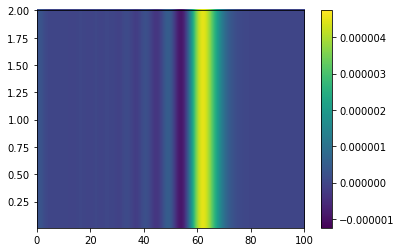

In [41]:
k = 50
u = -U[k, 0](None, None, 0).diff(0)
x = np.linspace(0, L, 3000)
r = np.abs(np.linspace(-R, R, 200))
heatmap(x, r, u(x, r))
plt.colorbar()

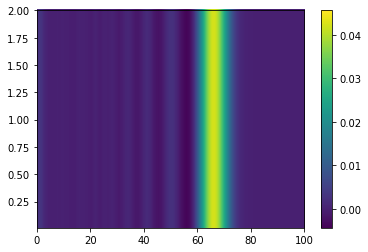

In [39]:
k = 50
u = -U[k, 0](None, None, 0).diff(0)
x = np.linspace(0, L, 3000)
r = np.abs(np.linspace(-R, R, 200))
heatmap(x, r, u(x, r))
plt.colorbar()

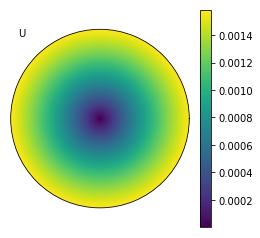

In [32]:
k = -1
x = 78.0
u = -U[k, 1].diff(0)
phi = np.linspace(0, 2*np.pi, 200)
r = np.abs(np.linspace(0.01, R, 200))
#heatmap(r, phi, u(x, r, phi))
#plt.colorbar()
plot(u, x)

In [45]:
fig, ax = plt.subplots()
plt.xlim(0, mesh_x.M)
plt.ylim(1e-7, 0.1)
plt.yscale('log')
lines = tuple(ax.plot([], [])[0] for i in range(mesh_x.M))
time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'Harmonic number')
plt.ylabel(r'Cefficients of $U_x(x, 0, 0)$')
plt.close()

def animate(k):
    u = -U[k, 0](None, 0, 0).diff()
    x = np.linspace(0, L, 3000)
    for l, f in zip(lines, u.func.reshape(mesh_x.M, -1)):
        l.set_data(np.arange(mesh_x.M), np.abs(legendre.legcoeff(f, 'Lobatto')))
    time_text.set_text(time_template % T[k])
    return lines + (time_text,)

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=50, blit=True)

In [46]:
anim

In [23]:
fig, ax = plt.subplots()
plt.xlim(0, L)
plt.ylim(-2e-2/4, 2e-2/2)
line, = ax.plot([], [])
time_template = 'time = %.1f'
time_text = ax.text(0.75, 0.9, '', transform=ax.transAxes)
plt.xlabel(r'$x$')
plt.ylabel(r'$U_x(x, 0, 0)$')
plt.close()

def animate(k):
    u = -U[k, 0](None, 0, 0).diff()
    x = np.linspace(0, L, 3000)
    line.set_data(x, u(x))
    time_text.set_text(time_template % T[k])
    return line, time_text

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(T), interval=50, blit=True)

In [24]:
anim

In [12]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, bitrate=1800)
anim.save('b_impact.mp4', writer=writer)

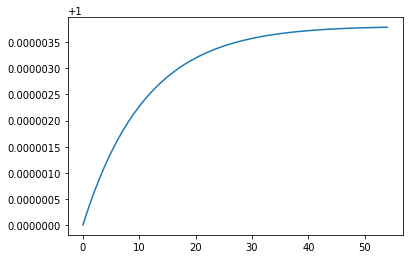

In [48]:
E_cut = E[60:]
plt.plot(E_cut/E_cut.max())
plt.savefig('energy_cut.png')

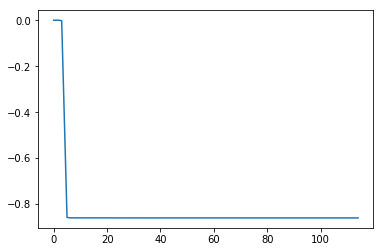

In [20]:
plt.plot(E)
plt.savefig('energy_full.png')